<a href="https://colab.research.google.com/github/zachaa2/Projects-ML-AI/blob/main/homework5/homework5_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task2 - Encoder/GAN

For this task, I will use the Tensorflow tutorial to implement the Variational Autoencoder, using the same encoder-decoder architecture as Tensorflow. [VAE Implementation in Tensorflow](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb). 

I will also implement the GAN (Generative Adversarial Network) to generate synthetic images. [GAN Implementation](https://www.tensorflow.org/tutorials/generative/dcgan). 

The tutorials are based on the MNIST dataset, a popular image dataset that contains images of handwritten numbers. I will be testing these implementations on a similar dataset - the Fashion MNIST dataset. This dataset contains images of different fashion catagories. This is a good substitute to the MNIST dataset because the images are of the same shape, and are greyscale.

### Variational Autoencoder

In [1]:
# import packages
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

Loading Data and Preprocessing

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# constants
train_size = 60000
batch_size = 32
test_size = 10000

In [4]:
def preprocess_images(images):
  # Reshape and normalize images 
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  # set values to 0 or 1 based on normalized values
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

Shuffle and Batch datat into two datasets

In [5]:

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

Convolutional Variational Autoencoder Class

In [6]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

Establish Optimizer and Define Loss Function



In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)




Define the Training Step - used to compute the gradients, and loss. Model params are updated using the gradients and the optimization algorithm. 

In [8]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Start the training Process

In [9]:
# num iterations
epochs = 10
# constants for visualization
latent_dim = 2
num_examples_to_generate = 16

# random vector and model declaration
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

Function to generate visualizations at a given epoch

In [10]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Sample the testing dataset

In [11]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -193.6428985595703, time elapse for current epoch: 5.294795036315918


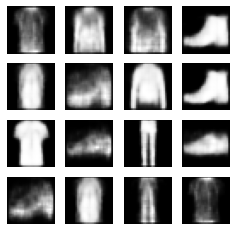

In [12]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

After just 10 epochs, we were able to generate images that look pretty similar to what their target class is supposed to be. Even without the images labeled with their actual class value, many are apparent. This is pretty incredible considering this was generated from an initial image with just noise. 

The Encoder network is based on a simple CNN design, and the Decoder network is essentially the mirror of the encoder. The VAE maps the input to parameters of probability distributions. As stated in the Tensorflow docs, "This approach produces a continuous, structured latent space, which is useful for image generation".

All NN work to maximize/minimize some objective function. In the case of VAE, the objective is to maximize the evidence lower bound (ELBO) on the marginal log-likelihood. 

The VAE generates images by sampling some sample z, and the generator will convert the sample to some distribution of logits. We can plot the distribution to generate the image. The above code does exactly this but for every epoch, so we can easily see how the VAE produces more accurate images over time. 

### Generative Adversarial Network (GAN) 

I will use the same fashion MNIST dataset, and train a GAN on it. Once again, I will follow the Tensorflow tutorial, which makes use of the keras Sequential API and the Gradient Tape to make a custom training step function. GAN work with two parts, the generator and the discriminator. The Generator will generate images from random noise, and the diesriminator will attempt to classify said images, and will itentify "good" and "bad" images. The idea is that the generator and discriminator will work together to generate synthetic images from random noise. 

The Generator network is based on the Conv2DTranspose (Deconvolution) layers, which essentially go the opposite way of the Convolutional Layer. 

The discriminator network is essentially just a CNN based image classifier. It will classify images, and output some values corresponding to whether an image is real or not. For example, an output may be positive for a real image, and negative for a fake one.  

In [18]:
from tensorflow.keras import layers

In [13]:
# Reload Fashion MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [14]:
# basic preprocessing
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [15]:
# constants
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [16]:
# shuffle data and create a batch
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Creating the Generator Model

In [17]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Let's use the untrained model to generate a test image

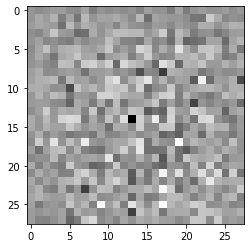

In [19]:
# create generator object
generator = make_generator_model()
# random vector
noise = tf.random.normal([1, 100])

# generate and show image
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Since the model is currently untrained, the generated image is going to be noise.

Let's build the discriminator by making a CNN based classifier

In [20]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Let's test the discriminator on the generator's image, and see what it decides.

In [21]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00071371]], shape=(1, 1), dtype=float32)


It returned a negative value as its prediction, indicating that it decided the image of random noise is not a valid image. 

Define Loss Functions for both networks

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
# function to calculate loss for the discriminator
# real images are compared against a vector of 1s 
# and fakes one against a vector of 0s
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [25]:
# function to calculate the loss for the generator
# For the generator, compare the fake images against 1s
# the intuition is that this will represent how well the generator can trick the discriminator
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Creating the Training Loop

In [28]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [29]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [31]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [32]:
# function to generate images @ each epoch
def generate_and_save_images(model, epoch, test_input):
  
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Training the model

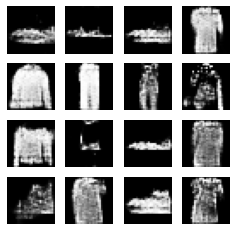

In [33]:
train(train_dataset, EPOCHS)

Just like the VAE, we have now used the GAN to generate synthetic images. The Result is quite incredible, considering the model starts from random noise, and must generate and classify images using the Generator/Discriminator model.